Local model with dendrites and 3 interneuron types. Contains AMPA, NMDA and GABA receptors. Dendritic inhibition is slower. NMDA/AMPA ratio an vary by cell type. Spike-frequency adaptation is present on non-PV neurons. The f-I curve is higher for PV neurons, and lower for E cells (thanks to Dan Bliss). Now contains an E--> SST cross connection (Adesnik et al., Nature, 2012). Sean Froudist-Walsh Aug/2019


In [68]:
# let's get what we need together
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import os
import copy

Define the current formulation of the dendrite input-output function (presuming $I_{inh}$ is negative)
<br>
<br>
$$ 
I_{soma,dendrite} = f_I(I_{exc},I_{inh}) = 
c_1.\biggl[\tanh\biggl(\dfrac{I_{exc} + c_3*I_{inh} + c_4}{c_5 e^{-I_{inh}/c6}}\biggr)\biggr] + c_2
$$

In [69]:
def dendrite_input_output(exc_current,inh_current,params):
    c1 = parameters['c1']
    c2 = parameters['c2']
    c3 = parameters['c3']
    c4 = parameters['c4']
    c5 = parameters['c5']
    c6 = parameters['c6']
    
    beta = c5*np.exp(-inh_current/c6)
    
    return c1*(np.tanh((exc_current +c3*inh_current + c4)/beta)) + c2

Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$


In [70]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'PV':
        c_I = parameters['c_I_PV']
        r_0 = parameters['r0_PV']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'SST':
        c_I = parameters['c_I_SST']
        r_0 = parameters['r0_SST']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'VIP':
        c_I = parameters['c_I_VIP']
        r_0 = parameters['r0_VIP']
        r = np.maximum(c_I*input_current + r_0,0)
        return r

        # NOTE: using python broadcasting for ones subtraction, so should work for multi-area case too

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [71]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the AMPA derivative 
<br>
$$ \frac{dS_{AMPA}}{dt} = -\frac{S_{AMPA}}{\tau_{AMPA}} + r_E$$
(Wong & Wang, 2006)

In [72]:
def AMPA_deriv(S_AMPA_prev,rate_now,parameters):
    
    return -S_AMPA_prev/parameters['tau_AMPA'] + rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [73]:
def GABA_deriv(S_GABA_prev,rate_now,parameters,cell_section):
    if cell_section == 'soma':
        return -S_GABA_prev/parameters['tau_GABA'] + parameters['gammai']*rate_now 
    elif cell_section == 'dendrite':
        return -S_GABA_prev/parameters['tau_GABA_dend'] + parameters['gammai']*rate_now

Define the adaptation current derivative
$$ \frac{dS_{a}}{dt} = -\frac{S_{a}}{\tau_{a}} + r $$
(Engel & Wang, 2001)

In [74]:
def adaptation_deriv(S_a_prev,rate_now,parameters):
    return -S_a_prev/parameters['tau_adapt'] + rate_now

In [235]:
parameters = {}
parameters.update({'SF1': 0.5, # Jorge M scaling factor to keep rates in check
                    'SF2': 2})    # Jorge M scaling factor to keep rates in check
                   
parameters.update({ # dendrite I/O function parameters
                    'c1': 120    * brian2.pA,
                    'c2': 136.24 * brian2.pA,
                    'c3': 7,
                    'c4': 0 * brian2.pA,
                    'c5': 9.64   * brian2.pA,
                    'c6': 20   * brian2.pA
})

parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_GABA_dend': 0.01  * brian2.second,    # s 
                    'tau_AMPA': 0.002  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 
                    'tau_adapt': 0.035   * brian2.second,    # s 
                    # f-I curve parameters - E populations
                    'a_E': 270. *parameters['SF1']  * brian2.Hz/brian2.nA,  # Hz/nA
                    'b_E': 108. *parameters['SF1']  * brian2.Hz,            # Hz
                    'd_E': 0.154*parameters['SF2']  * brian2.second,        # s
                    'gam': 0.641*parameters['SF2'],                         # unitless
                    # f-I curve parameters - I populations
                    'c_I_PV': 330 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'c_I_SST': 132 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'c_I_VIP': 132 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'gammai': parameters['SF2'],                       # unitless
                    # Local connectivity matrix strengths
                    # Strength of connections from E cells
                    'g_E_self': 0.37 * brian2.nA ,        # nA
                    'g_E_cross': 0.0107* brian2.nA,         # nA
                    'g_dend_soma': 0.0* brian2.nA,         # nA
                    'g_PV_E'  : 0.15 *brian2.nA,     # nA
                    'g_SST_E' : 0.05 *brian2.nA,      # nA
                    'g_SST_E_cross': 0.05 *brian2.nA,      # nA
                    'g_VIP_E': 0.06 *brian2.nA,      # nA
    
                    'g_soma_PV_min':  -0.15   * brian2.nA,         # nA    - sim 3 - distractible 2
                    'g_soma_PV_max':  -0.35   * brian2.nA,         # nA    - sim 3 - distractible 2

                    'g_PVself': -0.18   * brian2.nA,         # nA
    
                    # Strength of connections from SST cells
                    'g_PV_SST':   -0.18    * brian2.nA,         # nA
                    'g_VIP_SST':  -0.1    * brian2.nA,         # nA
                    'g_dend_SST_min': -0.1   * brian2.nA,      # nA 
                    'g_dend_SST_max': -0.2* brian2.nA,       # nA 

    
                     # Strength of connections from VIP cells
                    'g_SST_VIP':  -0.05    * brian2.nA,         # nA
    
                    # Strength of adapation - none for dendrites or PV cells
                    'g_adapt_E': -0.01 * brian2.nA,
                    'g_adapt_PV': 0 * brian2.nA,
                    'g_adapt_SST': -0.01 * brian2.nA,
                    'g_adapt_VIP': -0.01 * brian2.nA,

                # Background inputs
                    'I0_E': 0.31     * brian2.nA,         # nA
                    'I0_PV': 0.32       * brian2.nA,         # nA
                    'I0_SST': 0.28       * brian2.nA,         # nA
                    'I0_VIP': 0.28       * brian2.nA,         # nA
                    'I0_dend': 0.03    * brian2.nA,         # nA
                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA      
                    # initial values
                    'r0_E': 5 * brian2.Hz,
                    'r0_PV': -95 * brian2.Hz,
                    'r0_SST': -33 * brian2.Hz,
                    'r0_VIP': -33 * brian2.Hz

                        })      


parameters.update({ # Dopamine strength
                    'D1_strength': 1, # -  choose whether to have the D1 gradient implemented
                        })    


##### Receptor data #####
# Area 9/46v D1R receptor density
D1R_946v = 0.72

# Calculate how dopamine modulates PV-->soma strength (Gao et al., J Neurosci, 2003)
g_soma_PV_DA_mod = parameters['g_soma_PV_max'] + parameters['D1_strength']*D1R_946v*(parameters['g_soma_PV_min'] - parameters['g_soma_PV_max'])

# Calculate how dopamine modulates SST-->dendrite strength (Gao et al., J Neurosci, 2003)
g_dend_SST_DA_mod = parameters['g_dend_SST_min'] + parameters['D1_strength']*D1R_946v*(parameters['g_dend_SST_max'] - parameters['g_dend_SST_min'])

######## LOCAL CONNECTIONS WITH DOPAMINE MODIFICATION ########
J =  np.array([[parameters['g_E_self'] , parameters['g_E_cross'], parameters['g_dend_soma'], 0, parameters['g_PV_E'], parameters['g_SST_E'], parameters['g_SST_E_cross'],parameters['g_VIP_E'],0],
               [parameters['g_E_cross'] , parameters['g_E_self'],  0, parameters['g_dend_soma'], parameters['g_PV_E'], parameters['g_SST_E_cross'], parameters['g_SST_E'], 0, parameters['g_VIP_E']],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
              [g_soma_PV_DA_mod,g_soma_PV_DA_mod,0,0,parameters['g_PVself'], 0, 0,0,0],
              [0,0,0,0,parameters['g_PV_SST'], 0, 0,parameters['g_VIP_SST'],0],
              [0,0,0,0,parameters['g_PV_SST'], 0, 0, 0,parameters['g_VIP_SST']],
              [0,0,0,0,0,parameters['g_SST_VIP'],0,0,0],
              [0,0,0,0,0,0,parameters['g_SST_VIP'],0,0]
              ]).T * brian2.amp

pops = ['E1soma','E2soma','E1dend','E2dend','PV','SST1','SST2','VIP1','VIP2']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

df_J = pandas.DataFrame(J , columns=pops_column_list, index=pops_row_list)

num_pops  = J.shape[0]
num_E_pops = 2
num_dendrites = 2

######### adaptation ###########
g_adapt = np.array([parameters['g_adapt_E'],parameters['g_adapt_E'],0,0,parameters['g_adapt_PV'],
                    parameters['g_adapt_SST'],parameters['g_adapt_SST'],parameters['g_adapt_VIP']
                    ,parameters['g_adapt_VIP']])* brian2.amp 

######### AMPA:NMDA ratio ##########
parameters['local_AMPA_frac'] = np.array([0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1])
parameters['local_NMDA_frac'] = 1 - parameters['local_AMPA_frac']

J_NMDA = J*((J>0).astype(np.int))
J_AMPA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

J_GABA_dend =  np.array([[0,0,0,0,0,g_dend_SST_DA_mod,0,0,0],
               [0,0,0,0,0,0,g_dend_SST_DA_mod,0,0]]) * brian2.amp 

# Set up gradient, reflecting area 9/46v's position in the hierarchy
local_gradient = np.array([1.23,1.23,1.23,1.23,0.8,0.8,0.8,0.8,0.8])


# Choose initial values for rates and synapse variables
R0 = np.array([parameters['r0_E'],parameters['r0_E'],0,0,parameters['r0_E'],parameters['r0_E'],parameters['r0_E'],parameters['r0_E'],parameters['r0_E']])
S_NMDA0 = np.zeros((num_pops))
S_AMPA0 = np.zeros((num_pops))
S_GABA0 = np.zeros((num_pops))
S_GABA_dend0 = np.zeros((num_pops))
S_adapt0 = np.zeros((num_pops))


# Choose stimulus and distractor strength
stim_strength = 0.1 * brian2.nA
distractor_strength = 0.1 * brian2.nA



In [236]:
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=5000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R = np.zeros((num_iterations,num_pops)) * brian2.Hz
R[0,:] = R0* brian2.Hz
S_NMDA = np.zeros((num_iterations,num_pops))
S_NMDA[0,:] = S_NMDA0
S_AMPA = np.zeros((num_iterations,num_pops))
S_AMPA[0,:] = S_NMDA0
S_GABA = np.zeros((num_iterations,num_pops))
S_GABA[0,:] = S_GABA0
S_GABA_dend = np.zeros((num_iterations,num_pops))
S_GABA_dend[0,:] = S_GABA_dend0
S_adapt = np.zeros((num_iterations,num_pops))
S_adapt[0,:] = S_adapt0

# # Preassign external inputs
I_ext    = np.zeros((num_iterations,num_pops)) * brian2.amp
stim_on    = 1 * brian2.second #s
stim_off   = 1.5 * brian2.second #s
distract_on  = 2 * brian2.second #s
distract_off = 2.5 * brian2.second #s

# Let's apply external stimulation to V1 populations E1 & E2
I_ext[int(stim_on/dt):int(stim_off/dt),[pops.index('E1dend')]] = stim_strength
I_ext[int(distract_on/dt):int(distract_off/dt),[pops.index('E2dend')]] = distractor_strength

# Create matrices in which we can store the currents
I_local_NMDA =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_local_AMPA =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_soma_dend  =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_exc_dend   = np.zeros((num_iterations,num_E_pops)) * brian2.pA
I_inh_dend   = np.zeros((num_iterations,num_E_pops)) * brian2.pA
I_local_GABA_dend =  np.zeros((num_iterations,num_dendrites)) * brian2.pA
I_adapt = np.zeros((num_iterations,num_pops)) * brian2.pA

# # Define background inputs
I_0 = np.zeros((num_pops)) * brian2.pA
I_0[[pops.index('E1soma'),pops.index('E2soma')]] = parameters['I0_E']
I_0[[pops.index('E1dend'),pops.index('E2dend')]] = parameters['I0_dend']
I_0[[pops.index('PV')]] =  parameters['I0_PV']
I_0[[pops.index('SST1'),pops.index('SST2')]] = parameters['I0_SST']
I_0[[pops.index('VIP1'),pops.index('VIP2')]]  = parameters['I0_VIP']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_pops ))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])
noise_rhs[:,2:4] = 0 # remove noise from dendrites
I_noise = np.zeros((num_pops )) *brian2.pA

print(parameters['local_NMDA_frac']*local_gradient*J_NMDA.dot(S_NMDA[0,:].T))

[0. 0. 0. 0. 0. 0. 0. 0. 0.] A


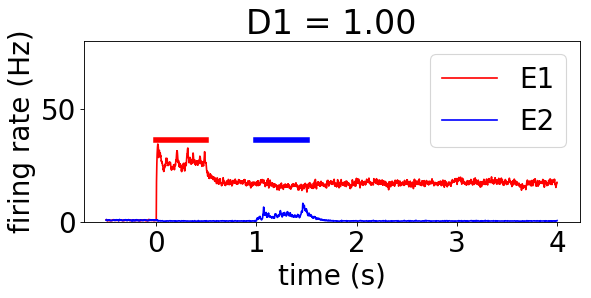

In [239]:

for i_t in range(1,num_iterations):
    
    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:]
    
    # local NMDA
    I_local_NMDA[i_t-1,:] = parameters['local_NMDA_frac']*local_gradient*J_NMDA.dot(S_NMDA[i_t-1,:].T).T
    
    # local AMPA
    I_local_AMPA[i_t-1,:] = parameters['local_AMPA_frac']*local_gradient*J_AMPA.dot(S_AMPA[i_t-1,:].T).T

    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:] = J_GABA.dot(S_GABA[i_t-1,:].T).T
    
    # sum up all the local GABA current onto dendrites
    I_local_GABA_dend[i_t-1,:] = J_GABA_dend.dot(S_GABA_dend[i_t-1,:].T).T
    
    # calculate the dendrite-to-soma current
    I_exc_dend[i_t-1,:] = I_local_NMDA[i_t-1,2:4]  + I_local_AMPA[i_t-1,2:4]  + I_0[2:4] + I_ext[i_t-1,2:4] + I_noise[2:4]
    I_inh_dend[i_t-1,:] = I_local_GABA_dend[i_t-1,:]

    I_soma_dend[i_t-1,:2]  = dendrite_input_output(I_exc_dend[i_t-1,:],I_inh_dend[i_t-1,:],parameters)
    
    # adaptation current
    I_adapt[i_t-1,:] = g_adapt*S_adapt[i_t-1,:]
    
    
    # Define total input current as sum of local NMDA & GABA inputs, with background and external currents, 
    # noise and long-range NMDA inputs, and an adaptation current
    I_total[i_t-1,:] = I_local_NMDA[i_t-1,:] + I_local_AMPA[i_t-1,:] +  I_local_GABA[i_t-1,:] + I_0 + I_ext[i_t-1,:] + I_noise + I_soma_dend[i_t-1,:] + I_adapt[i_t-1,:]
    
    
    # Update the firing rates of the two excitatory populations.
    R[i_t,:2] = R[i_t-1,:2] + dt*current_to_frequency(I_total[i_t-1,:2],'E',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,:2]/parameters['tau_AMPA']
    
    # Update the firing rates of the PV population. 
    R[i_t,4] =  R[i_t-1,4] + dt*current_to_frequency(I_total[i_t-1,4],'PV',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,4]/parameters['tau_AMPA']

    # Update the firing rates of the SST populations. 
    R[i_t,5:7] =  R[i_t-1,5:7] + dt*current_to_frequency(I_total[i_t-1,5:7],'SST',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,5:7]/parameters['tau_AMPA']
    
    # Update the firing rates of the VIP populations. 
    R[i_t,7:] =  R[i_t-1,7:] + dt*current_to_frequency(I_total[i_t-1,7:],'VIP',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,7:]/parameters['tau_AMPA']

    
    # Update the NMDA synapses
    S_NMDA[i_t,:2] = S_NMDA[i_t-1,:2] + dt*NMDA_deriv(S_NMDA[i_t-1,:2],R[i_t,:2],parameters)
    
    # Update the AMPA synapses
    S_AMPA[i_t,:2] = S_AMPA[i_t-1,:2] + dt*AMPA_deriv(S_AMPA[i_t-1,:2],R[i_t,:2],parameters)

    # Update the GABA synapses onto the somata
    S_GABA[i_t,4:] = S_GABA[i_t-1,4:] + dt*GABA_deriv(S_GABA[i_t-1,4:],R[i_t,4:],parameters,'soma')
    
    # Update the GABA synapses onto the dendrites
    S_GABA_dend[i_t,4:] = S_GABA_dend[i_t-1,4:] + dt*GABA_deriv(S_GABA_dend[i_t-1,4:],R[i_t,4:],parameters,'dendrite')
    
    # Update the adaptation variable
    S_adapt[i_t,:] = S_adapt[i_t-1,:] + dt*adaptation_deriv(S_adapt[i_t-1,:],R[i_t,:],parameters)
    
fig=plt.figure(figsize=(8,3), dpi= 80, facecolor='w', edgecolor='k')
start_time = 0.5 #seconds
end_time = 5 #seconds
plt.rcParams.update({'font.size': 25})

plt.title("D1 = %0.2f" % parameters['D1_strength'])
# # Plot the rates for the E1 soma
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),0],color='r')
# # Plot the rates for the E2 soma
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),1],color='b')

# Plot the stimulation time
plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R[:,:2]+0.05*np.max(R[:,:2])),np.max(R[:,:2]+0.05*np.max(R[:,:2]))],color='r',linewidth=5.0)
   
# Plot the distractor time
plt.plot([distract_on-1*brian2.second,distract_off-1*brian2.second],[np.max(R[:,:2]+0.05*np.max(R[:,:2])),np.max(R[:,:2]+0.05*np.max(R[:,:2]))],color='b',linewidth=5.0)
 
axes.text(0.15, 0.8,'cue', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='r')
axes.text(0.3, 0.8,'distractor', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='b')

plt.legend(['E1','E2'])
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.ylim(0, 80) 

# Hide the right and top spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')


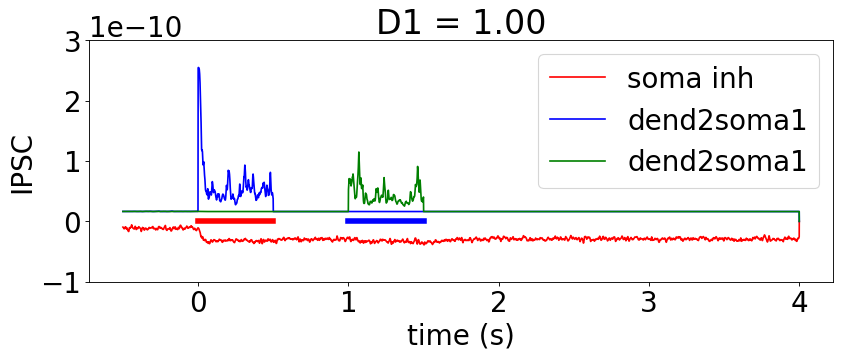

In [238]:
fig=plt.figure(figsize=(12,4), dpi= 80, facecolor='w', edgecolor='k')
start_time = 0.5 #seconds
end_time = 5 #seconds
plt.rcParams.update({'font.size': 25})

plt.title("D1 = %0.2f" % parameters['D1_strength'])
# # Plot the inhibitory current to the soma (both E cells)
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),I_local_GABA[np.arange(int(start_time/dt),int(end_time/dt),1),0],color='r')
# # Plot the inhibitory currrent to the dendrite (E1)
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),I_soma_dend[np.arange(int(start_time/dt),int(end_time/dt),1),0],color='b')
# # Plot the inhibitory currrent to the dendrite (E2)
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),I_soma_dend[np.arange(int(start_time/dt),int(end_time/dt),1),1],color='g')


# Plot the stimulation time
plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(I_local_GABA[:,:2]+0.05*np.max(I_local_GABA[:,:2])),np.max(I_local_GABA[:,:2]+0.05*np.max(I_local_GABA[:,:2]))],color='r',linewidth=5.0)
   
# Plot the distractor time
plt.plot([distract_on-1*brian2.second,distract_off-1*brian2.second],[np.max(I_local_GABA[:,:2]+0.05*np.max(I_local_GABA[:,:2])),np.max(I_local_GABA[:,:2]+0.05*np.max(I_local_GABA[:,:2]))],color='b',linewidth=5.0)
 
axes.text(0.15, 0.8,'cue', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='r')
axes.text(0.3, 0.8,'distractor', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='b')

plt.legend(['soma inh','dend2soma1','dend2soma1'])
plt.xlabel('time (s)')
plt.ylabel('IPSC')
plt.ylim(-10e-11, 30e-11) 

# Hide the right and top spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
